In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')
sys.path.append('../../PerFreqOS')

from defiant import OptimalStatistic
from defiant import utils

### Load up MDC1 pulsars

In [2]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


### Create a PTA object

In [4]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

### Now create the defiant OptimalStatistic object

In [7]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',corepath='MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [8]:
xi_range = np.linspace(0.01,np.pi,1000)
hd_mod = utils.orf_xi(xi_range,orf='hd')
dp_mod = utils.orf_xi(xi_range,orf='dipole')
mn_mod = utils.orf_xi(xi_range,orf='monopole')

In [9]:
from scipy.stats import multivariate_normal

def get_total_MCOS_model(A2):
    return A2[0]*hd_mod + A2[1]*dp_mod + A2[2]*mn_mod


### Now we need to run through each option, inspect its validity, and save the outputs

# Test 1: OS

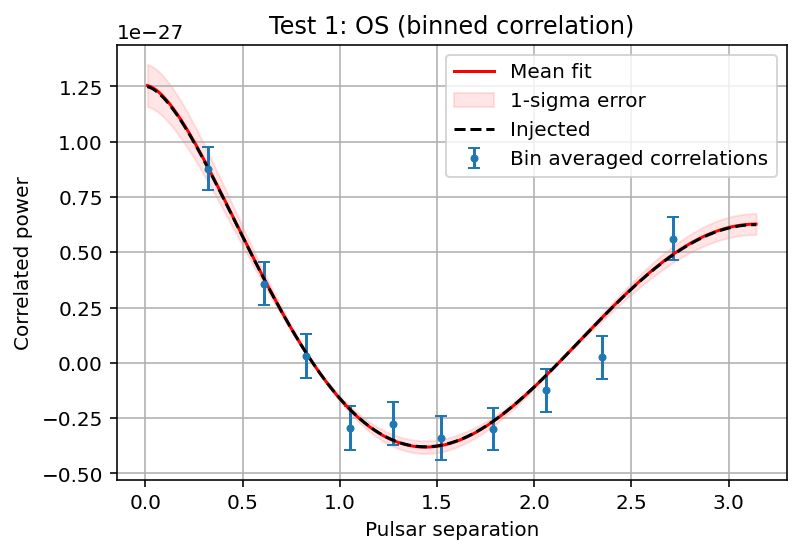

In [6]:
OS_obj.set_orf(['hd'])
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, N=1, pair_covariance=False, return_pair_vals=True)

plt.title('Test 1: OS (binned correlation)')
xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rho,sig,bins=10)
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
plt.plot(xi_range,A2*hd_mod,'-r',label='Mean fit')
plt.fill_between(xi_range,(A2-A2s)*hd_mod,(A2+A2s)*hd_mod,color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

# Test 2: NM+OS

100%|██████████| 1000/1000 [00:07<00:00, 136.51it/s]


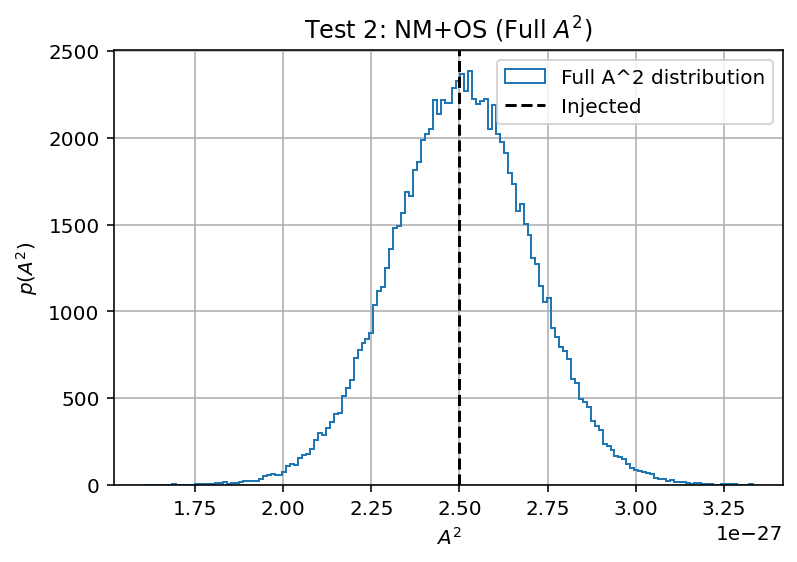

In [7]:
OS_obj.set_orf(['hd'])
A2,A2s,idx = OS_obj.compute_OS(N=1000, pair_covariance=False, return_pair_vals=False)

plt.title('Test 2: NM+OS (Full $A^2$)')
full_A2 = utils.uncertainty_sample(A2,A2s)
plt.hist(full_A2,bins='auto',histtype='step',label='Full A^2 distribution')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='k',label='Injected')

plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Test 3: PC+OS

Pairs of pairs: 100%|███████████████| 198765/198765 [00:00<00:00, 619648.16it/s]


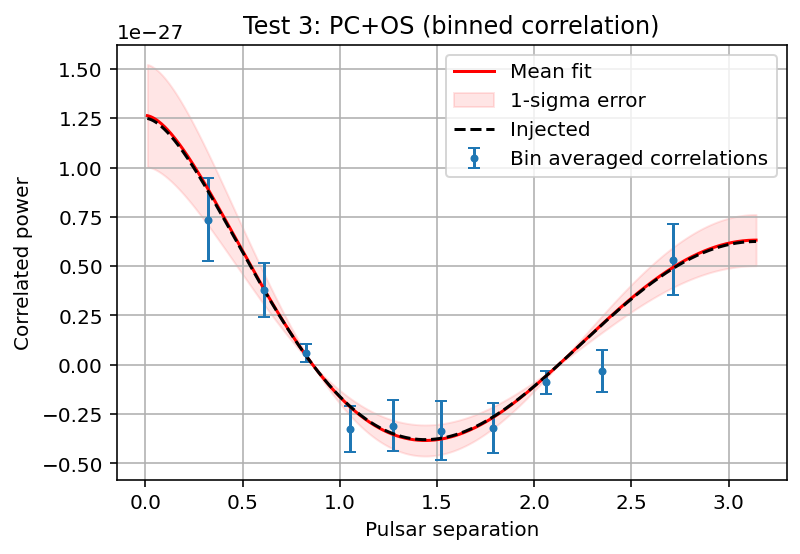

In [8]:
OS_obj.set_orf(['hd'])
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, N=1, pair_covariance=True, return_pair_vals=True)

plt.title('Test 3: PC+OS (binned correlation)')
xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rho,C,bins=10,orf='hd')
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
plt.plot(xi_range,A2*hd_mod,'-r',label='Mean fit')
plt.fill_between(xi_range,(A2-A2s)*hd_mod,(A2+A2s)*hd_mod,color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

# Test 4: PC+NM+OS

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


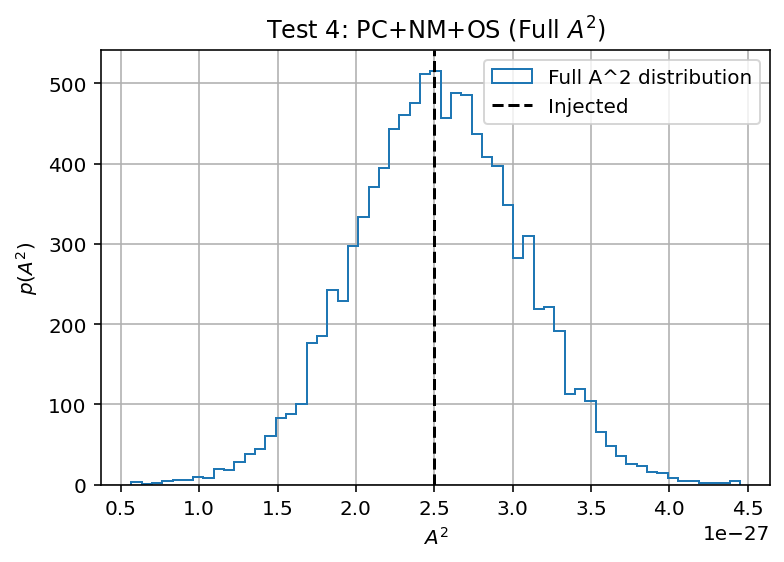

In [9]:
OS_obj.set_orf(['hd'])
A2,A2s,idx = OS_obj.compute_OS(N=100, pair_covariance=True, return_pair_vals=False)

plt.title('Test 4: PC+NM+OS (Full $A^2$)')
full_A2 = utils.uncertainty_sample(A2,A2s)
plt.hist(full_A2,bins='auto',histtype='step',label='Full A^2 distribution')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='k',label='Injected')

plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Test 5: narrow PF+OS

100%|██████████| 10/10 [00:00<00:00, 2031.34it/s]


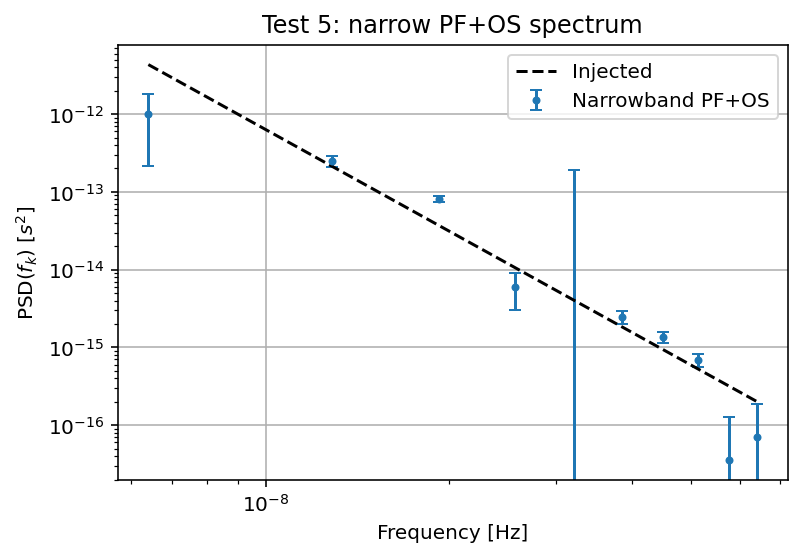

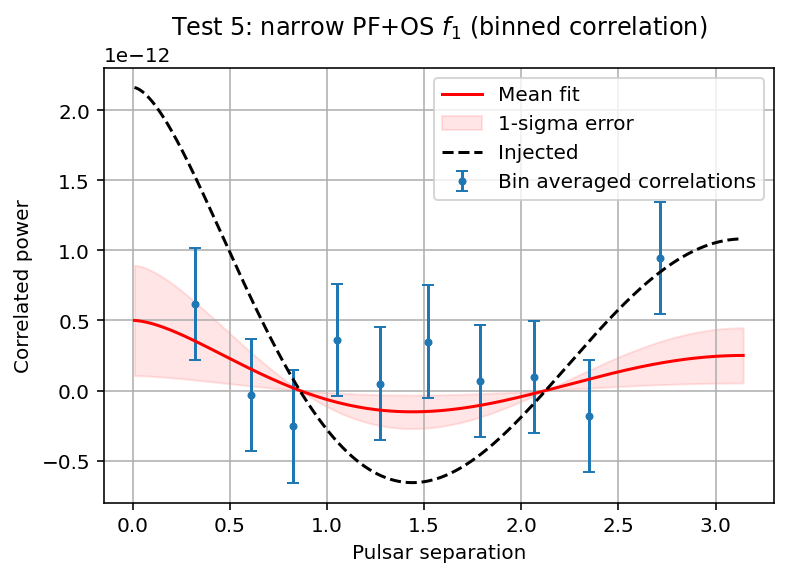

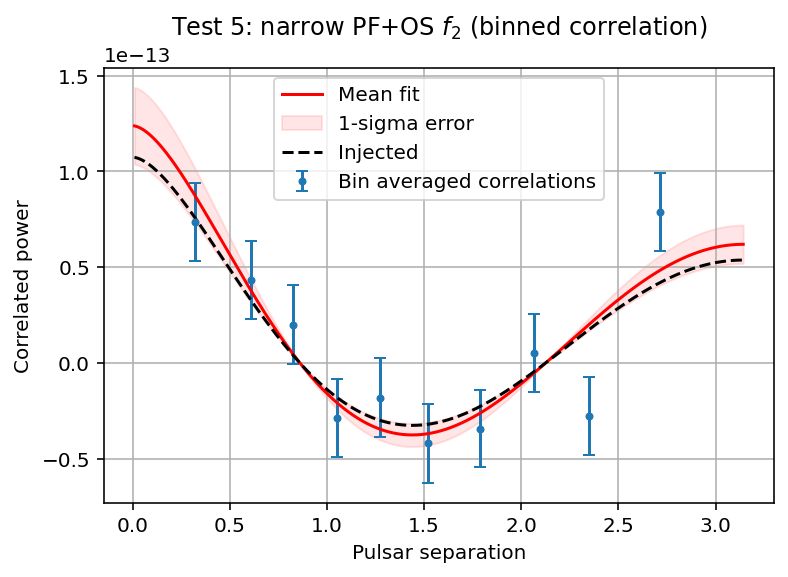

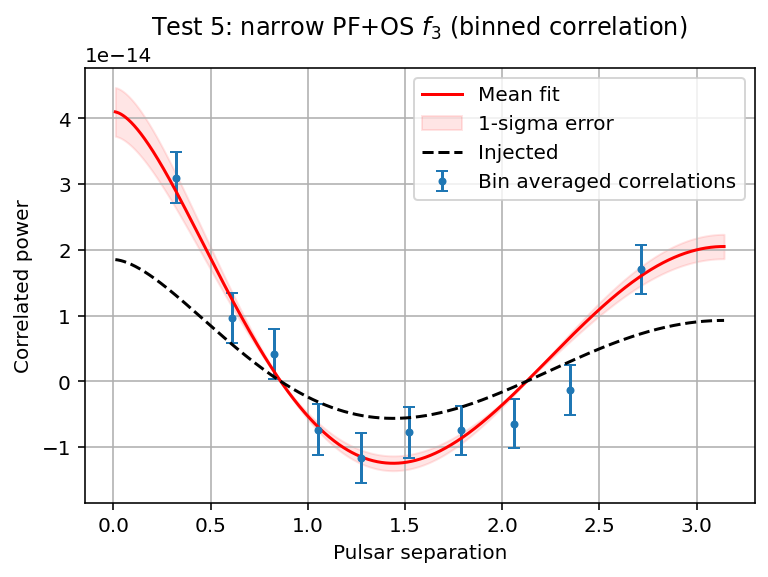

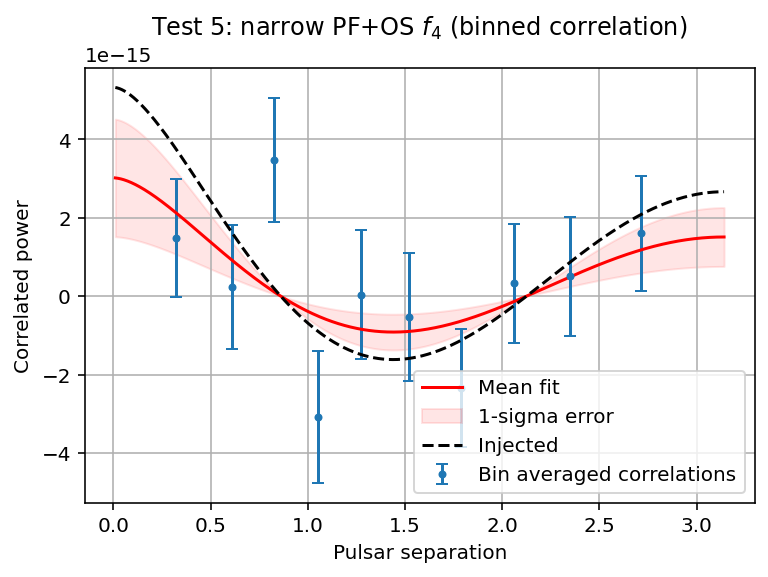

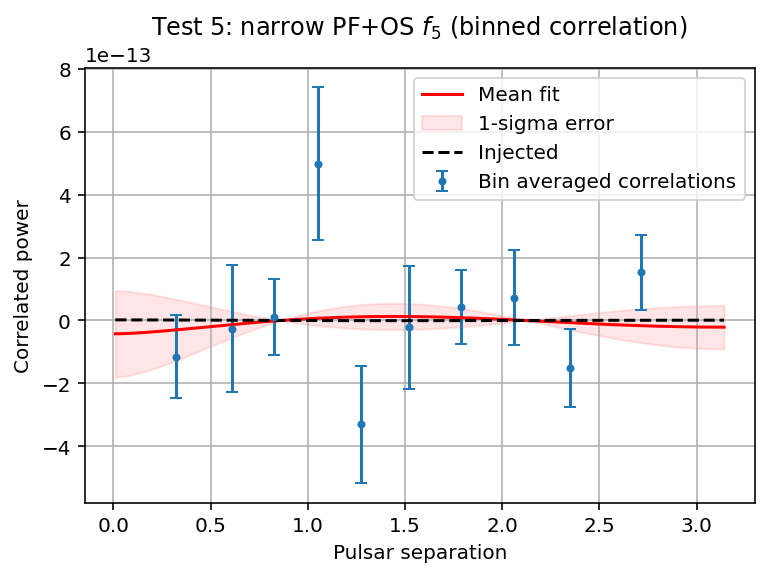

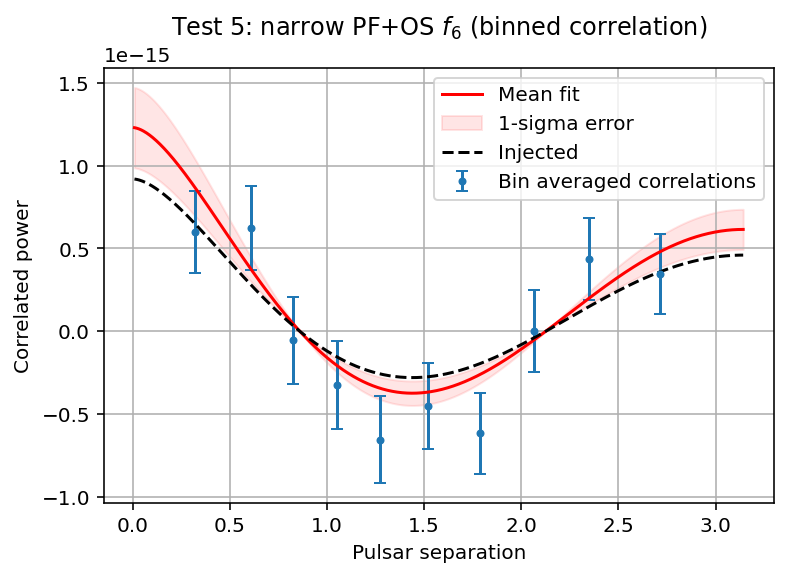

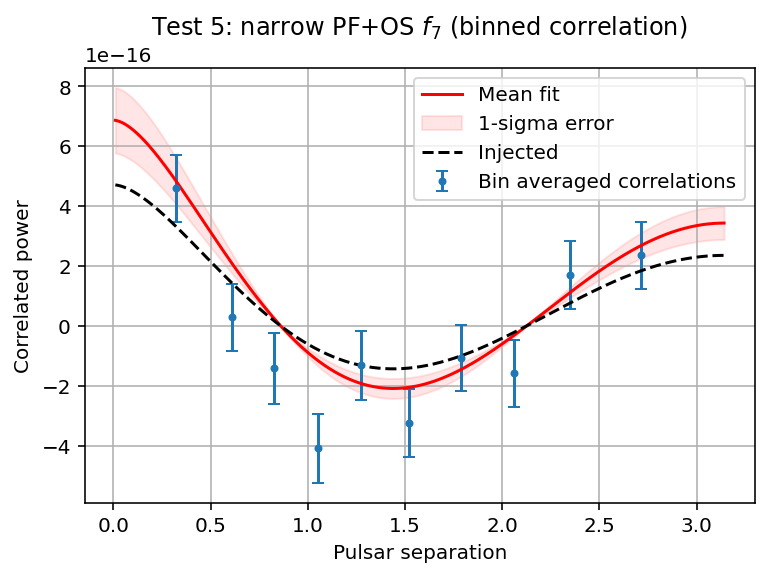

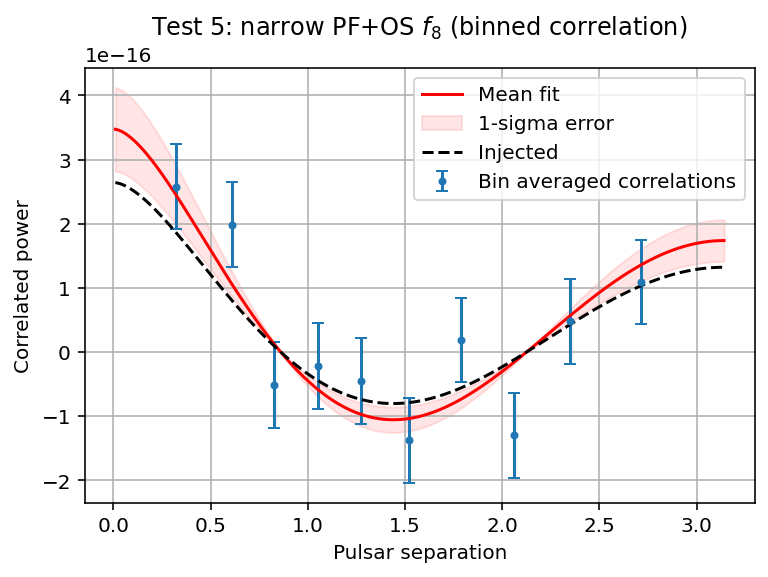

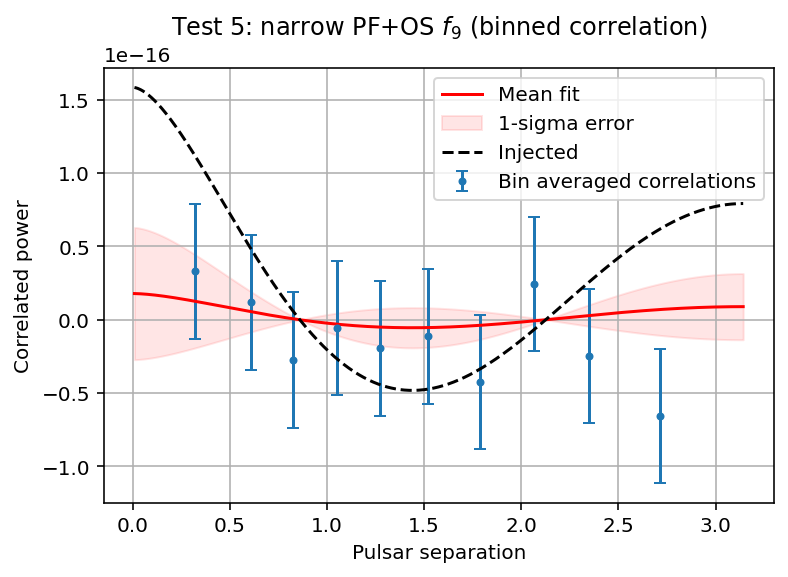

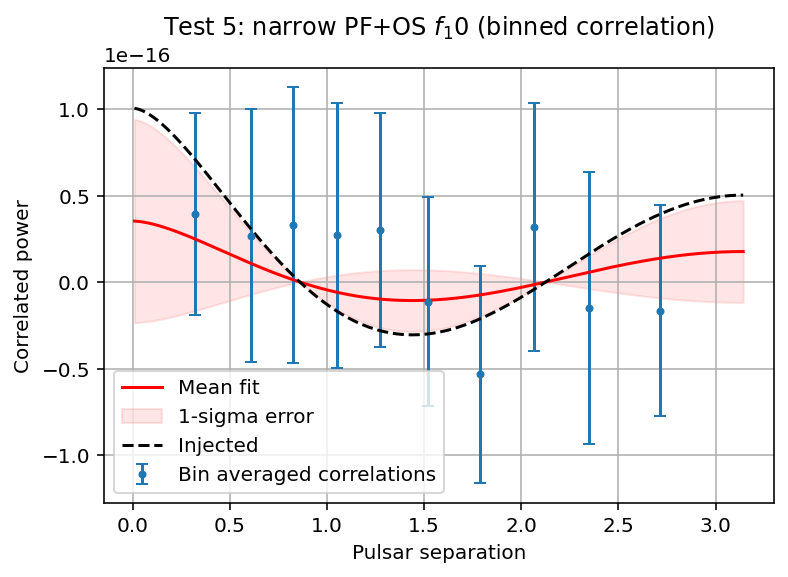

In [10]:
OS_obj.set_orf(['hd'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=False, 
                                             return_pair_vals=True, narrowband=True)
fgw = OS_obj.freqs

plt.title('Test 5: narrow PF+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 5: narrow PF+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10)
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 6: narrow PF+NM+OS

100%|██████████| 1000/1000 [00:32<00:00, 31.15it/s]


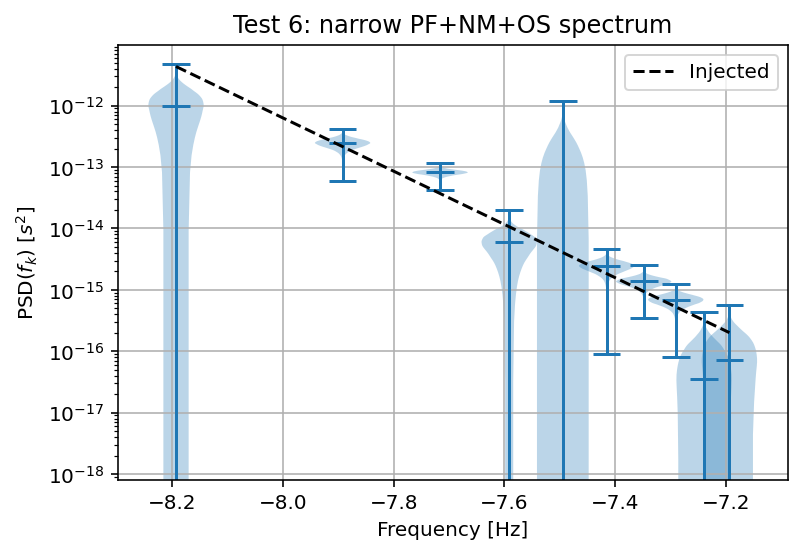

In [11]:
OS_obj.set_orf(['hd'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, pair_covariance=False, 
                                 return_pair_vals=False, narrowband=True)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 6: narrow PF+NM+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 7: narrow PF+PC+OS

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


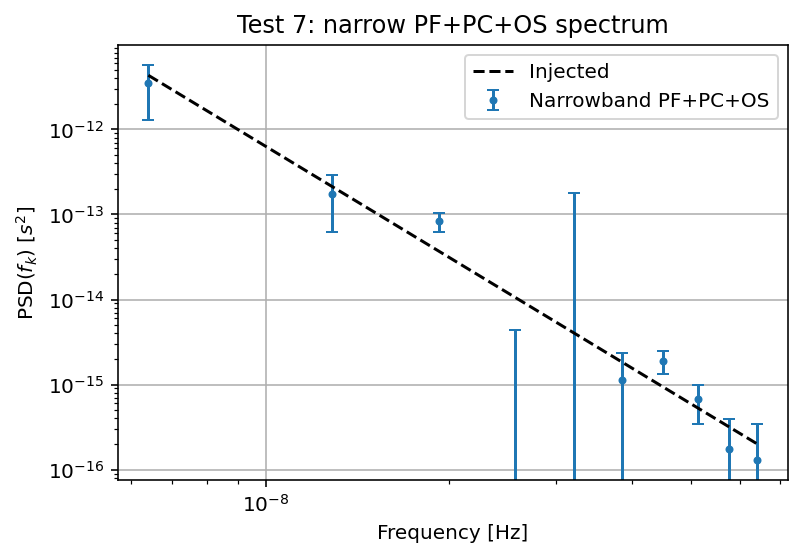

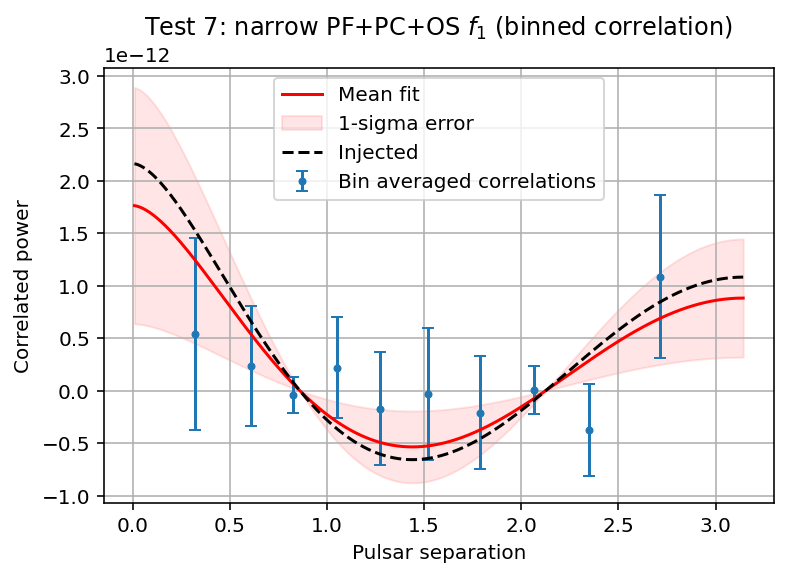

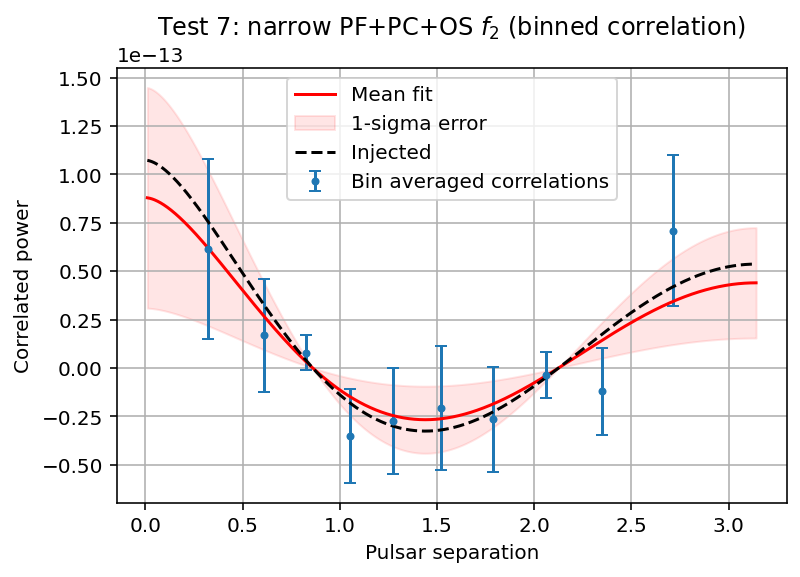

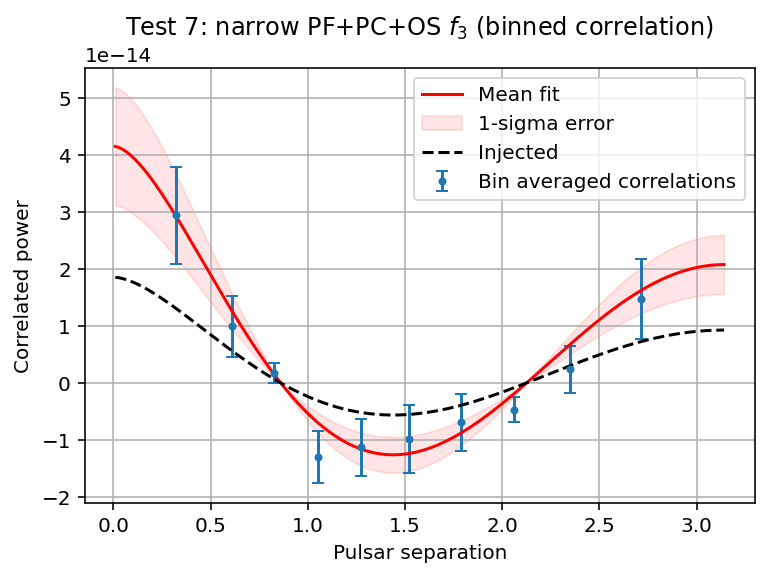

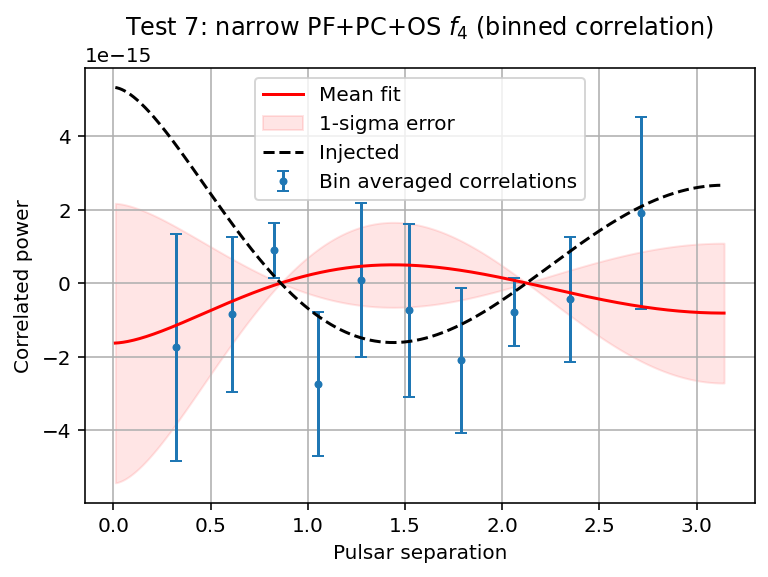

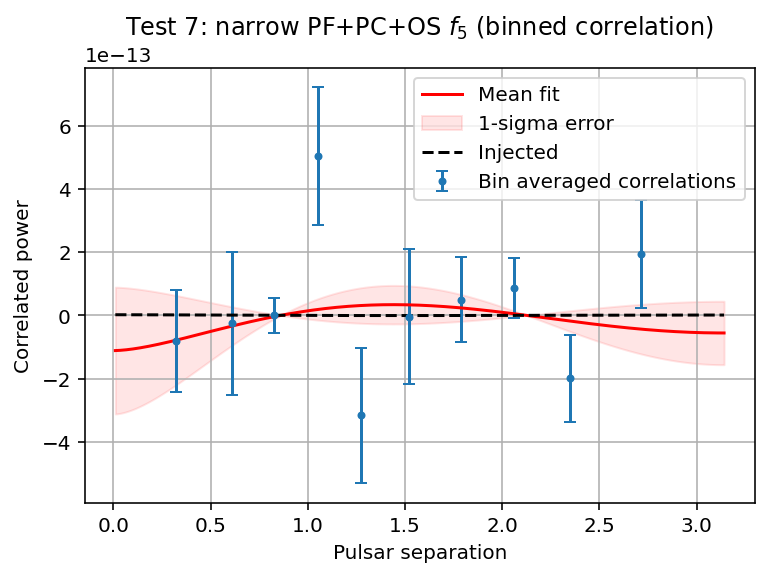

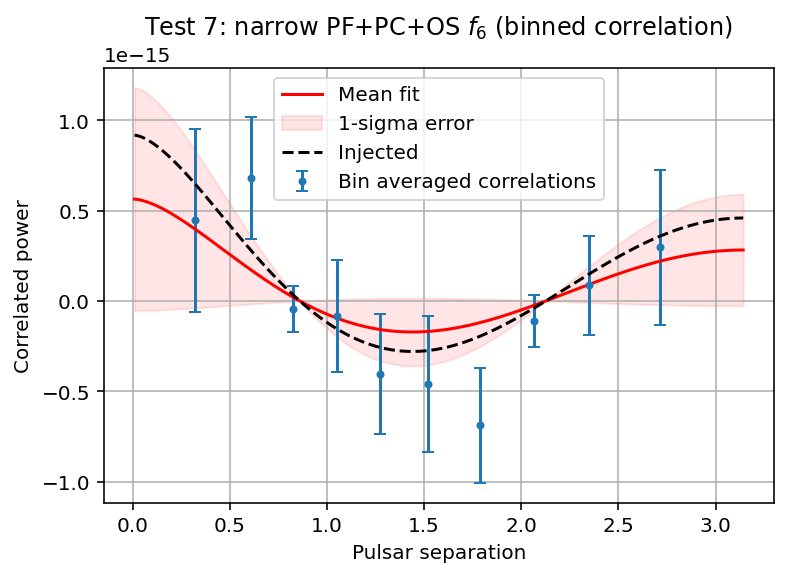

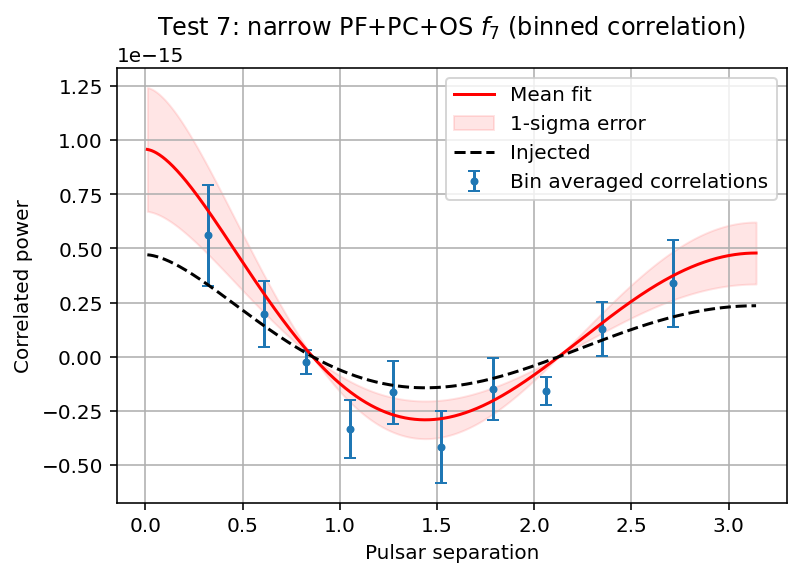

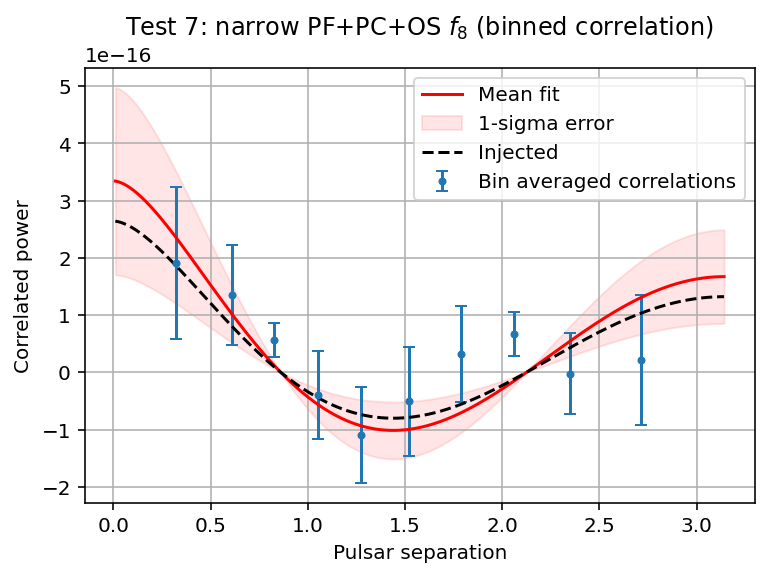

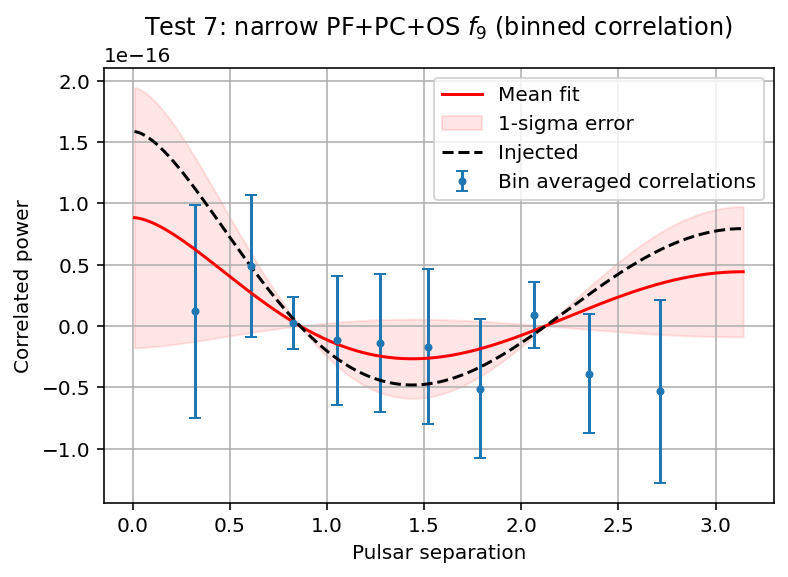

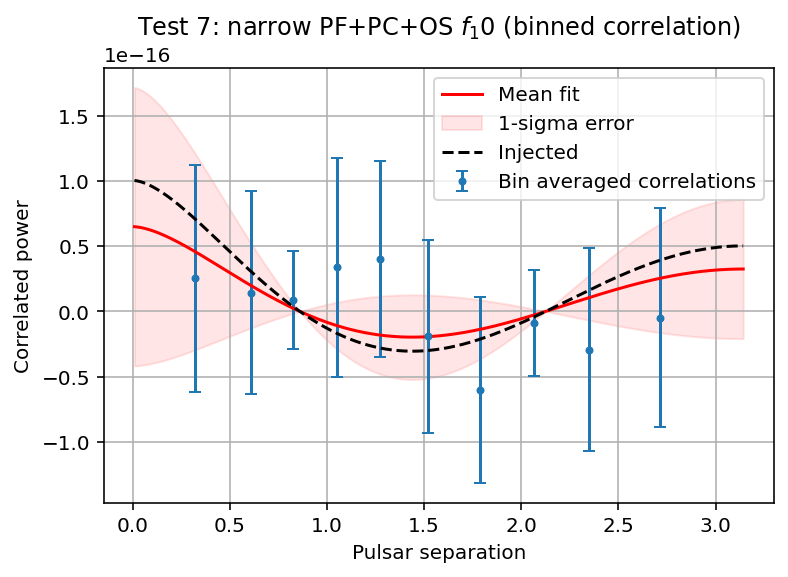

In [12]:
OS_obj.set_orf(['hd'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=True, 
                                             return_pair_vals=True, narrowband=True)
fgw = OS_obj.freqs

plt.title('Test 7: narrow PF+PC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+PC+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 7: narrow PF+PC+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],Ck[k],bins=10,orf='hd')
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 8: narrow PF+PC+NM+OS

100%|██████████| 100/100 [11:09<00:00,  6.69s/it]


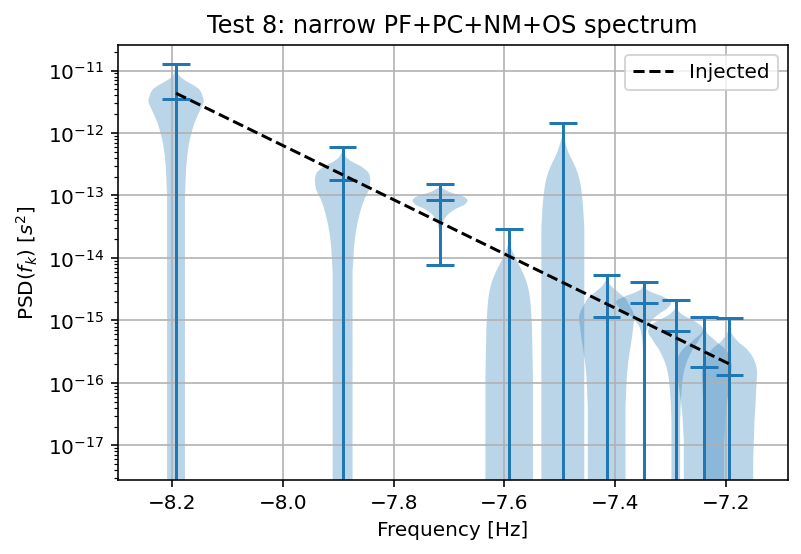

In [13]:
OS_obj.set_orf(['hd'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=True)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 8: narrow PF+PC+NM+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 9: PF+OS

100%|██████████| 10/10 [00:00<00:00, 1412.79it/s]


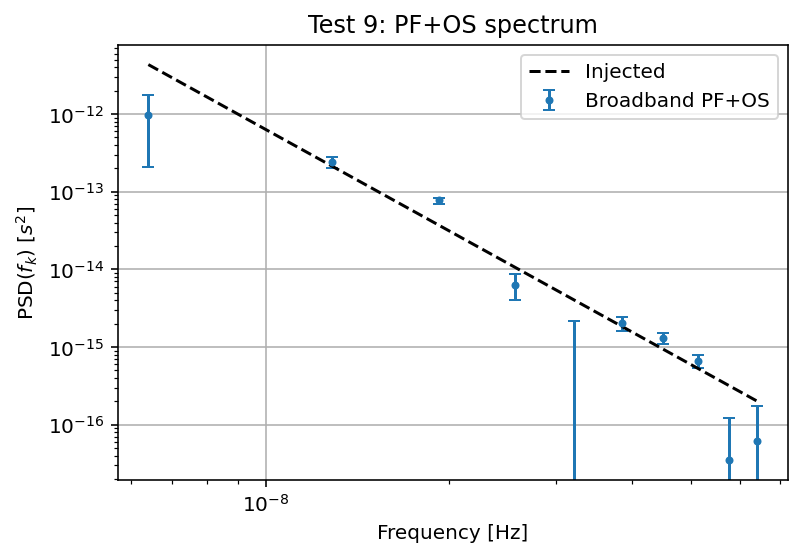

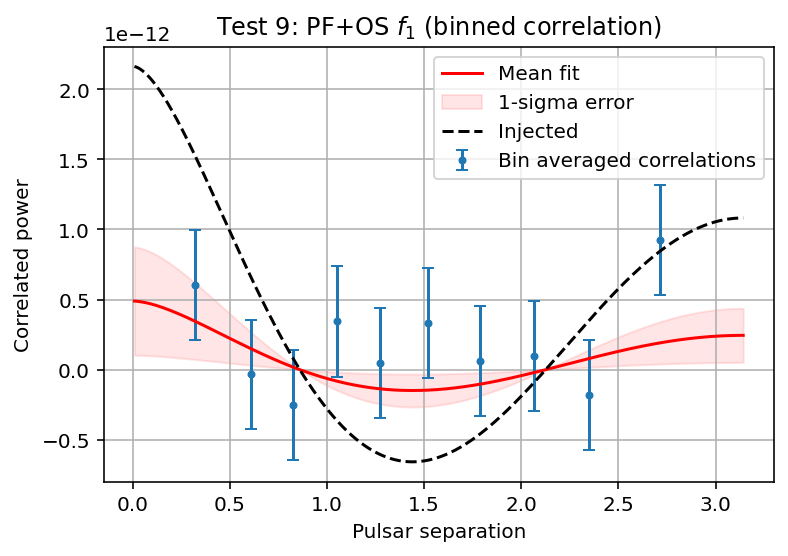

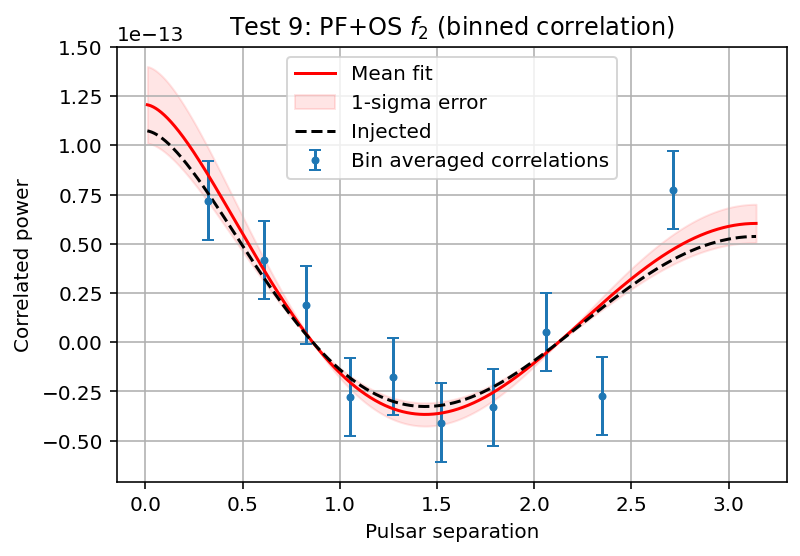

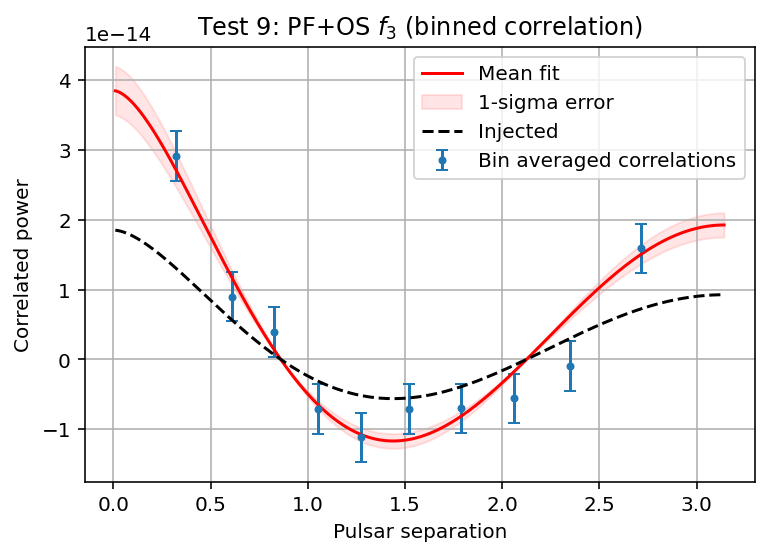

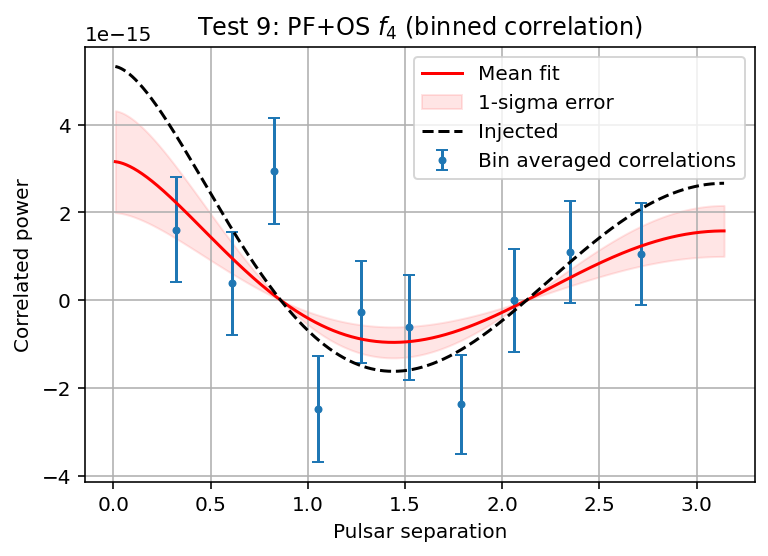

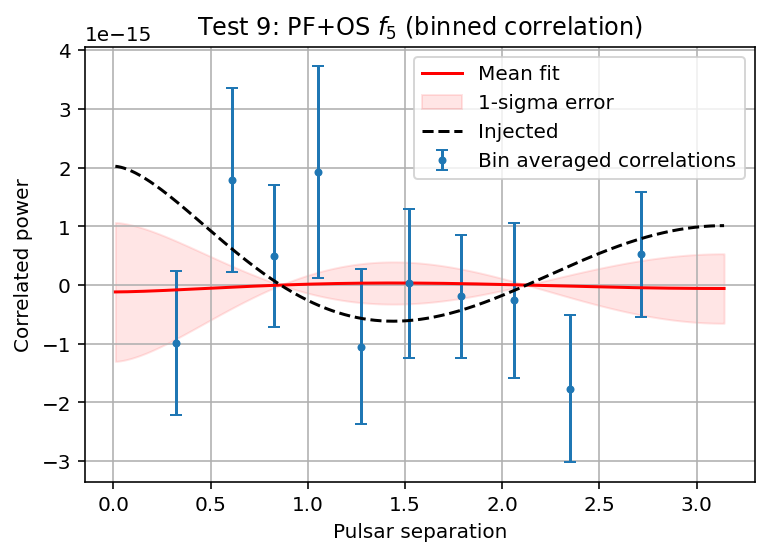

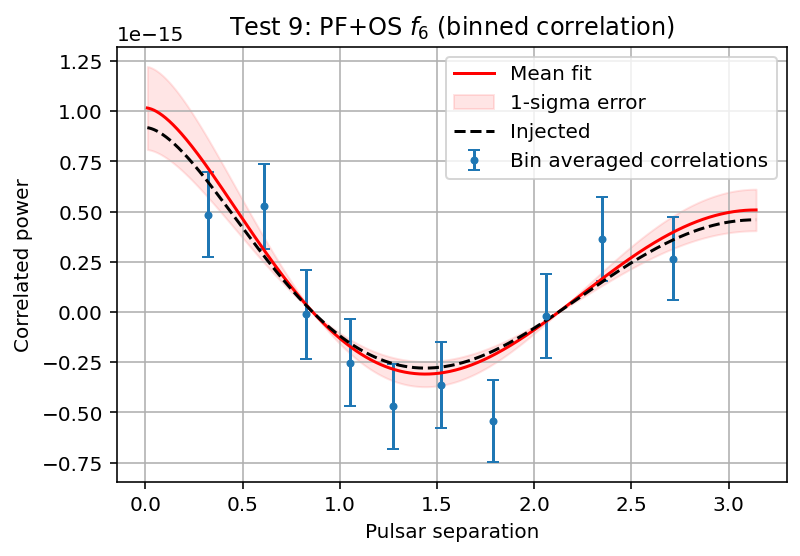

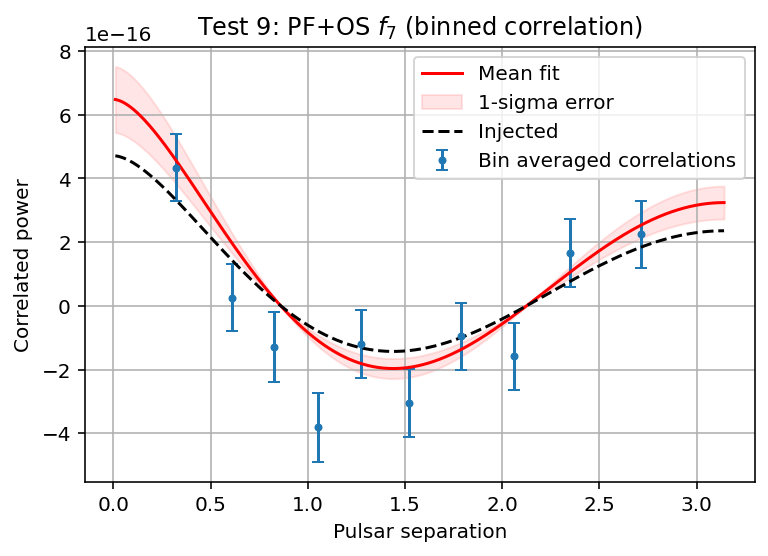

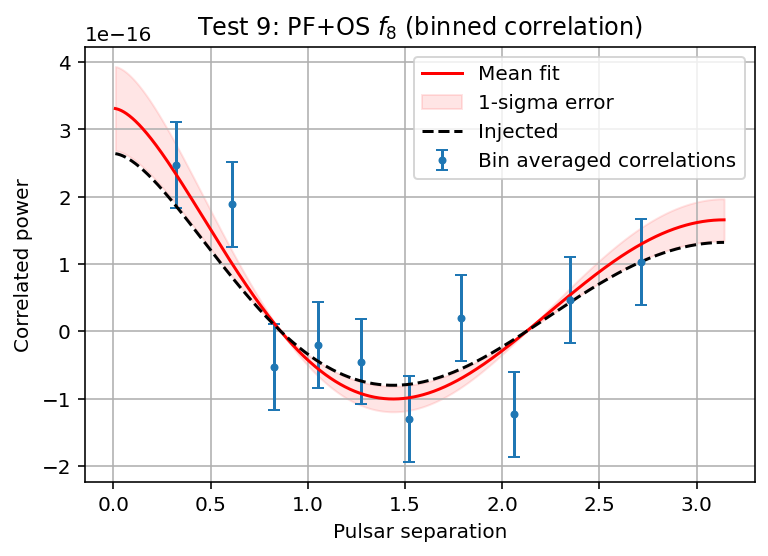

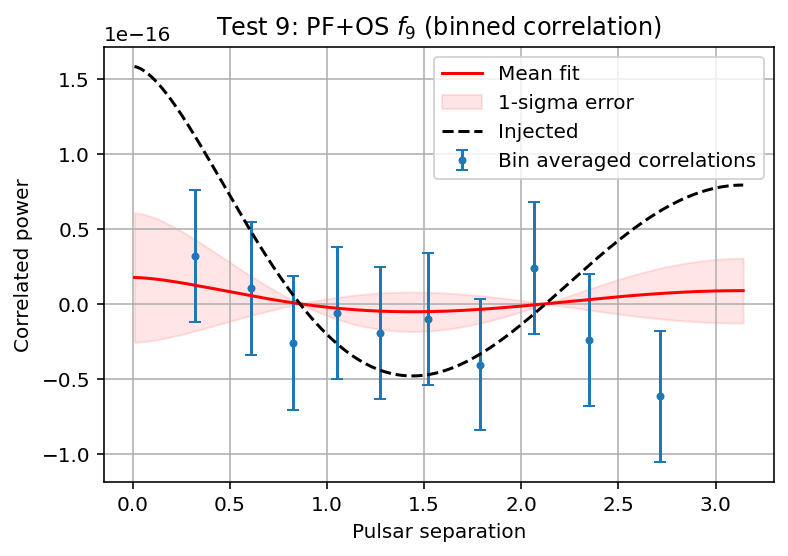

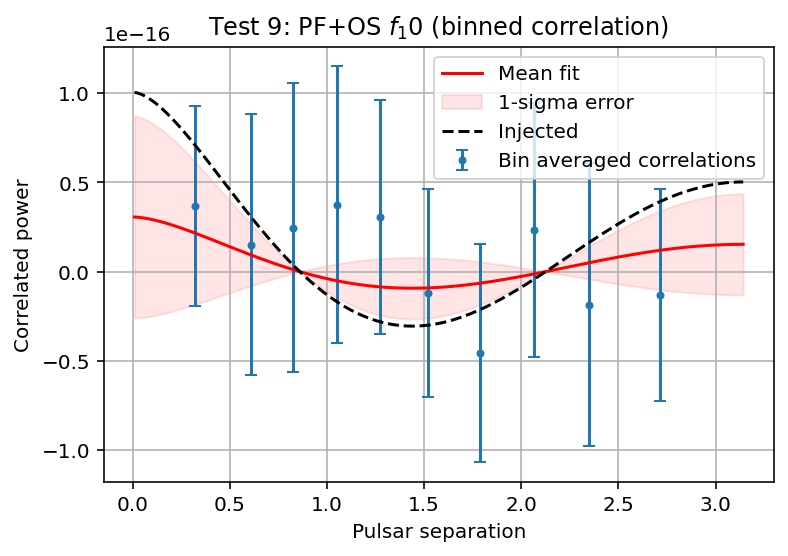

In [14]:
OS_obj.set_orf(['hd'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=False, 
                                             return_pair_vals=True, narrowband=False)
fgw = OS_obj.freqs

plt.title('Test 9: PF+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 9: PF+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10)
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 10: PF+NM+OS

100%|██████████| 1000/1000 [00:31<00:00, 31.95it/s]


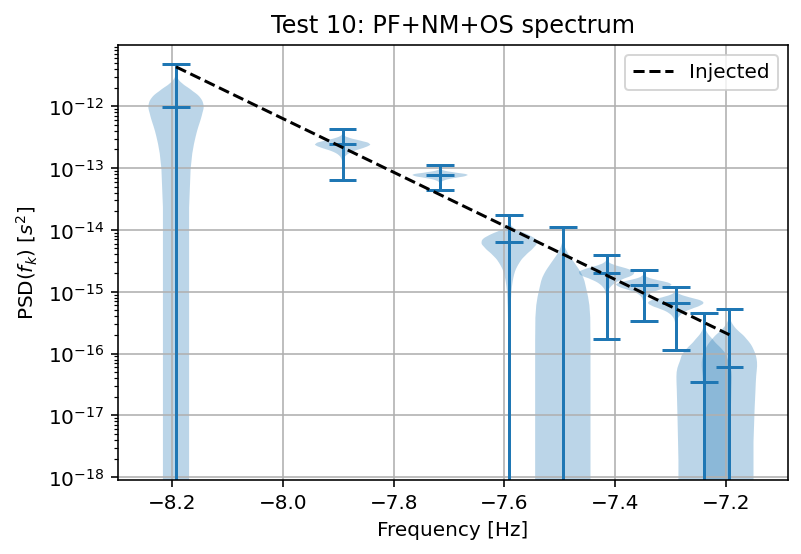

In [15]:
OS_obj.set_orf(['hd'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, pair_covariance=False, 
                                 return_pair_vals=False, narrowband=False)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 10: PF+NM+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 11: PF+PC+OS

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


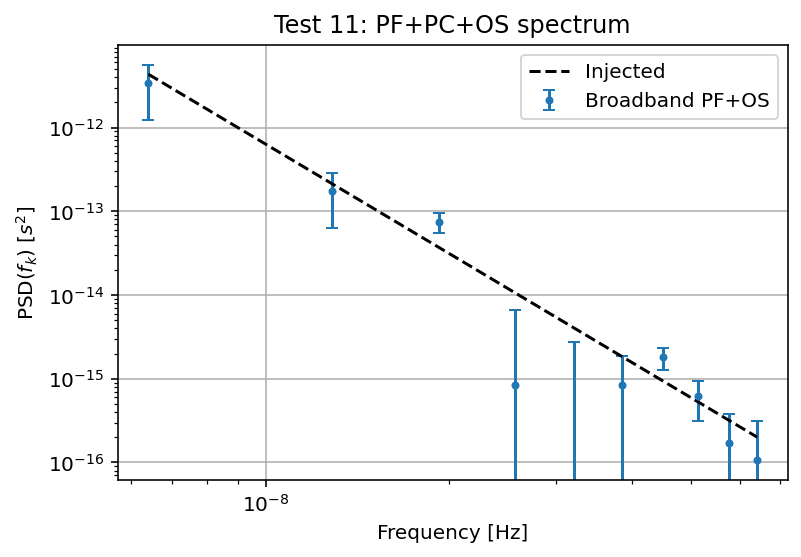

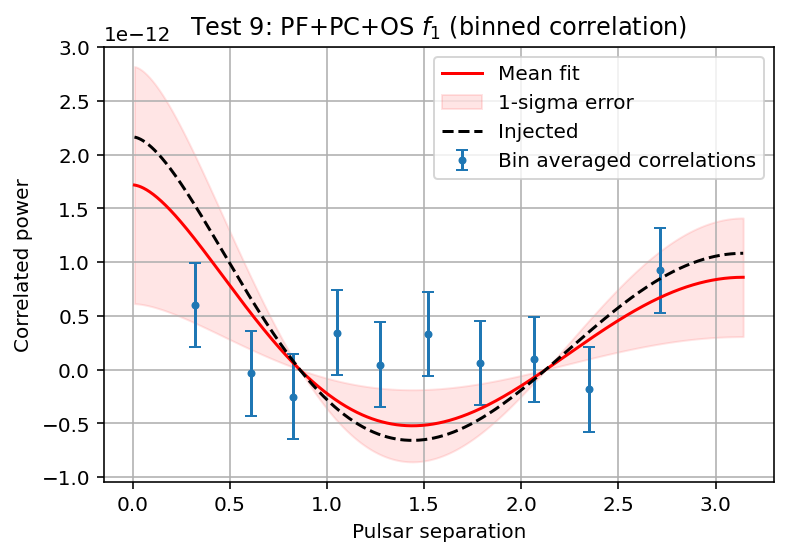

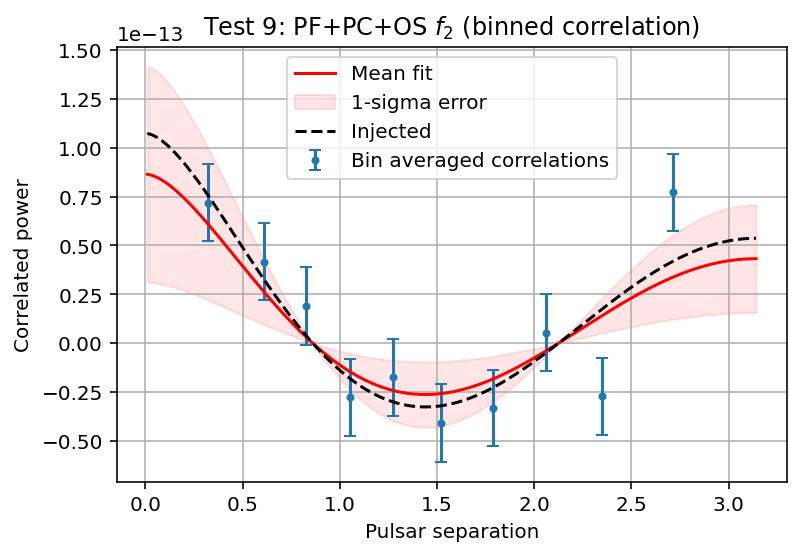

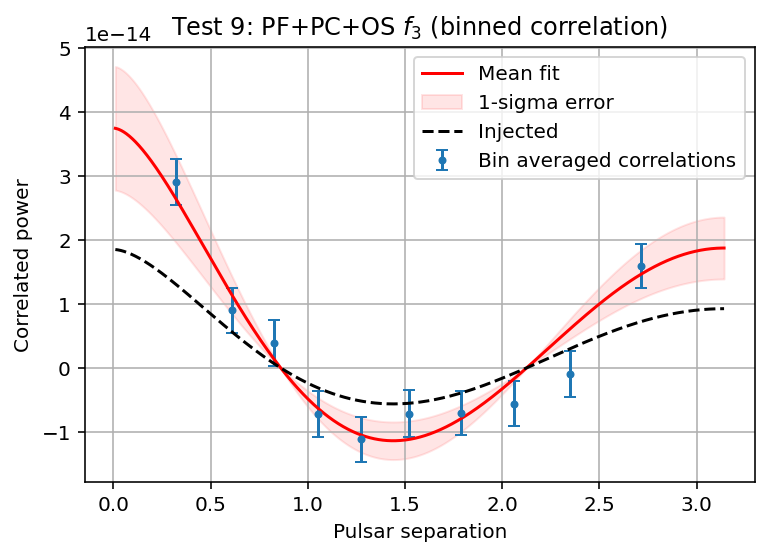

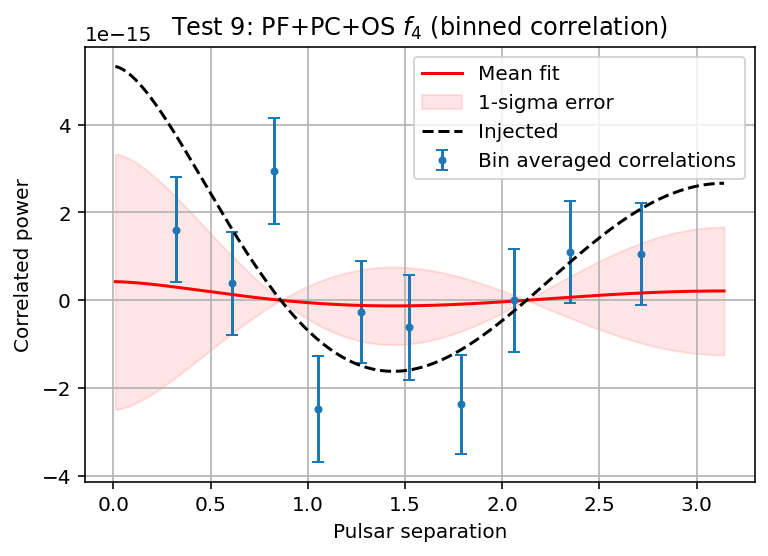

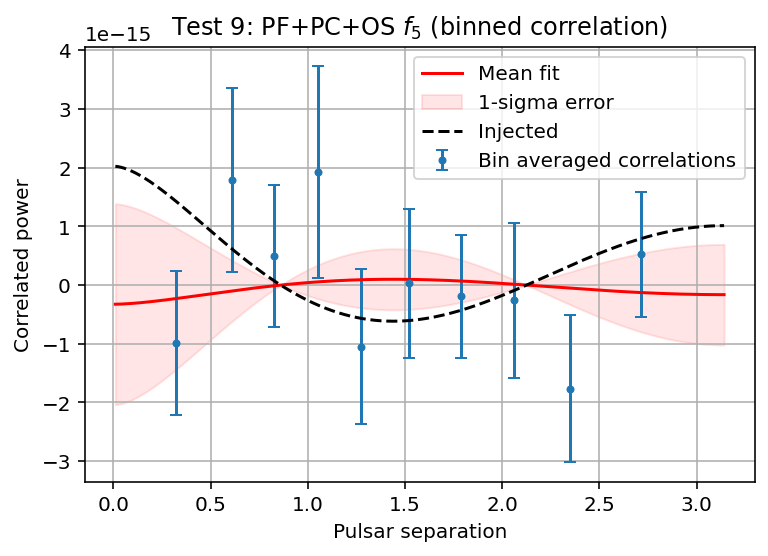

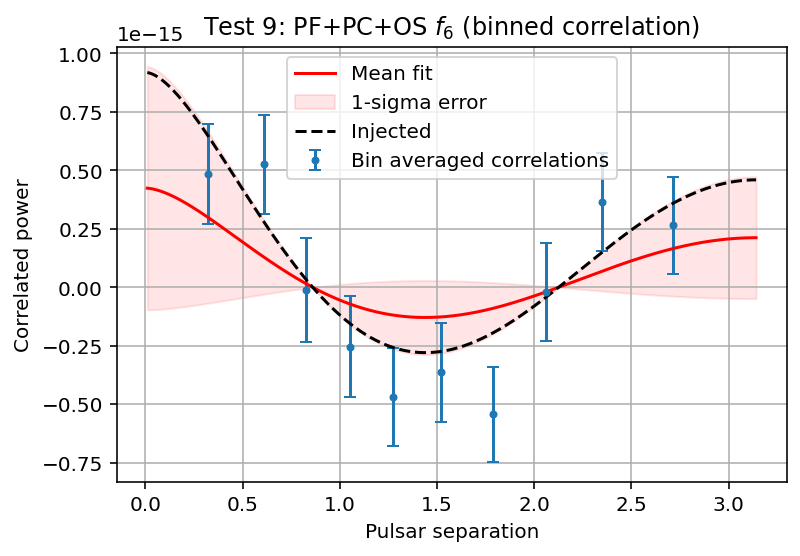

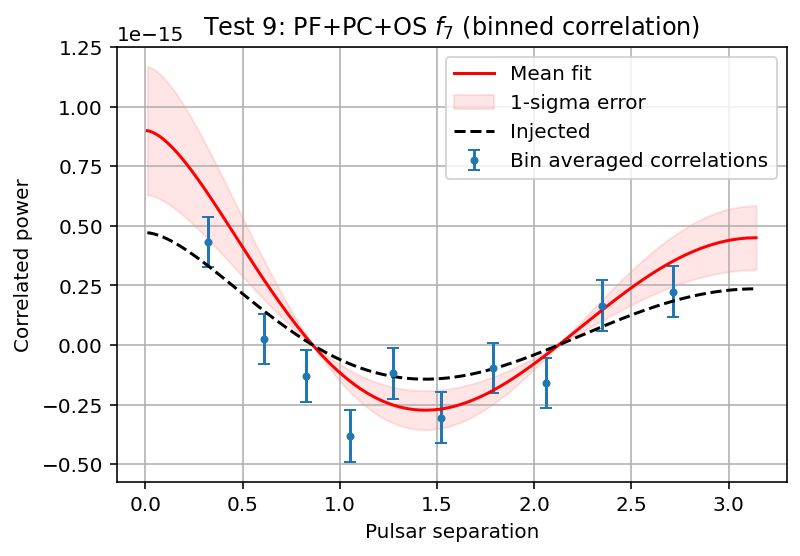

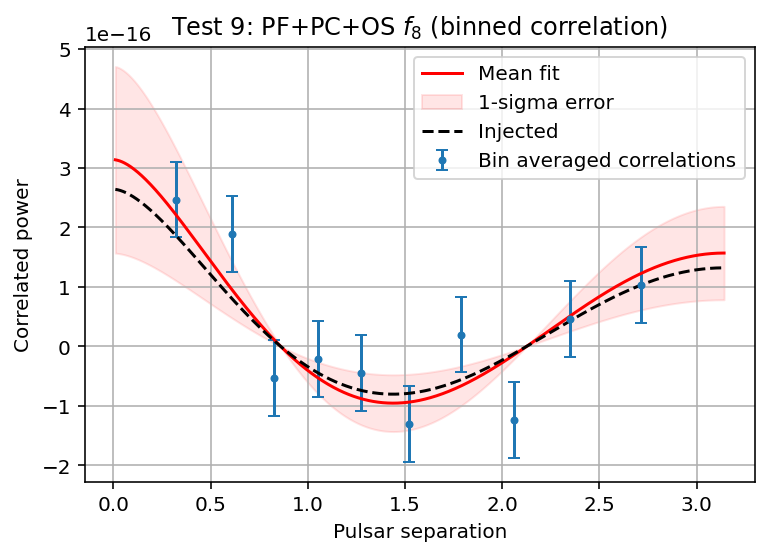

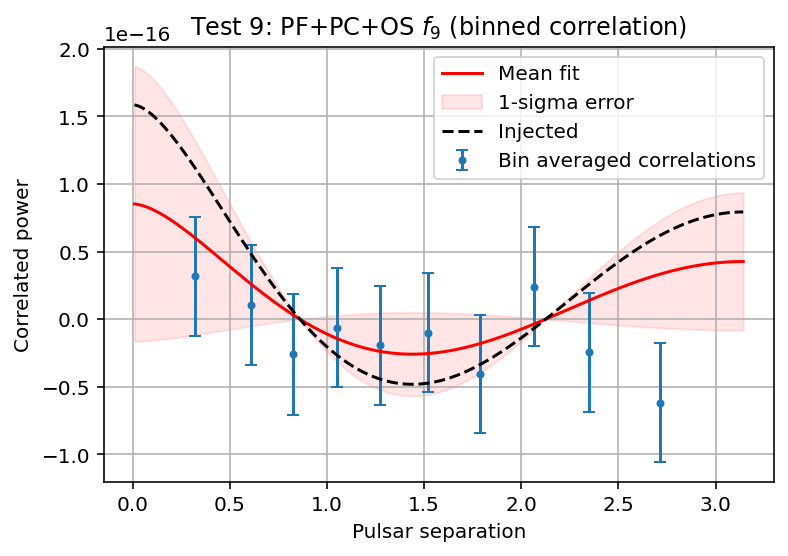

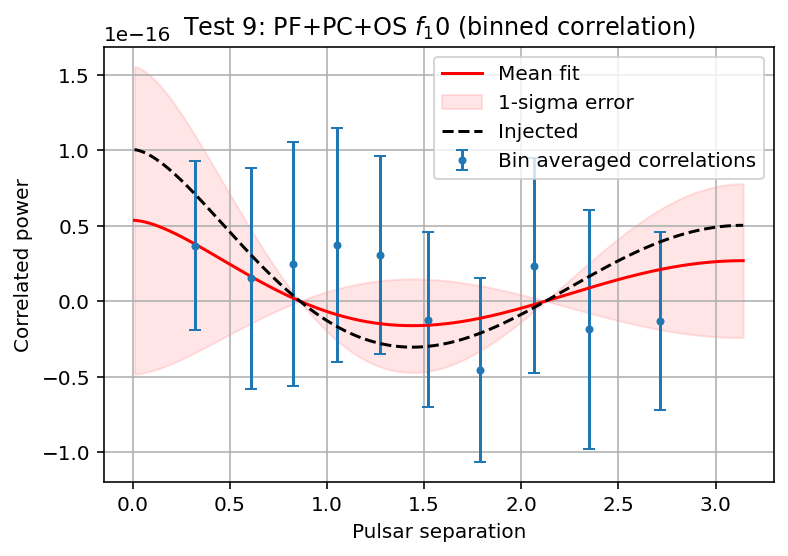

In [16]:
OS_obj.set_orf(['hd'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=True, 
                                             return_pair_vals=True, narrowband=False)
fgw = OS_obj.freqs

plt.title('Test 11: PF+PC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 9: PF+PC+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10,orf='hd')
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 12: PF+PC+NM+OS

100%|██████████| 100/100 [11:11<00:00,  6.72s/it]


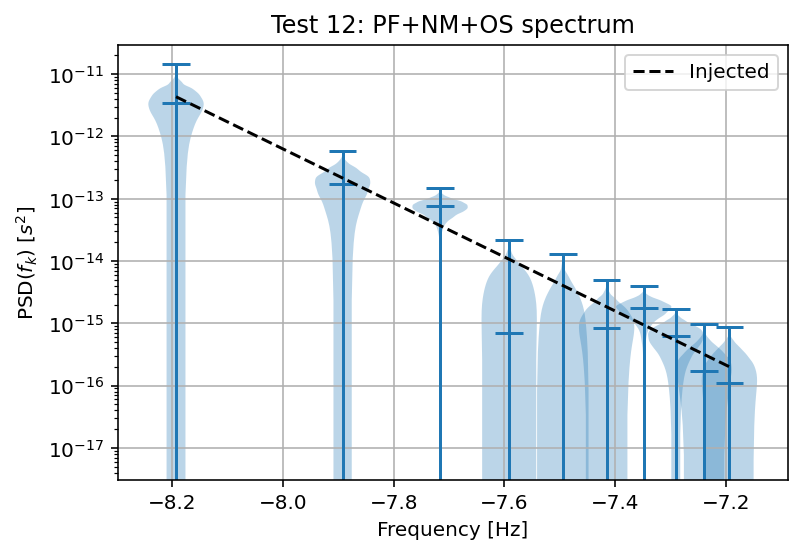

In [17]:
OS_obj.set_orf(['hd'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=False)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 12: PF+NM+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 13: MC+OS

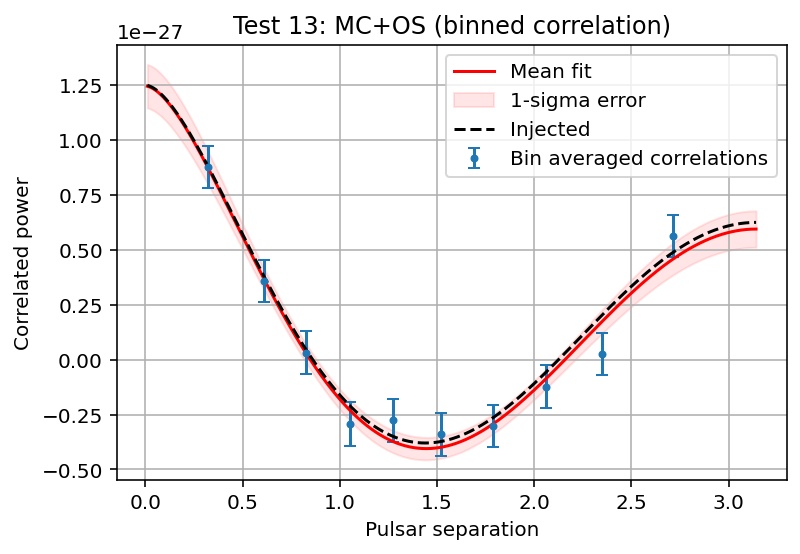

In [11]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, N=1, pair_covariance=False, return_pair_vals=True)

plt.title('Test 13: MC+OS (binned correlation)')
xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rho,sig,bins=10)
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
cor_mean,cor_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,A2s,['hd','dipole','monopole'])
plt.plot(xi_range,cor_mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(cor_mean-cor_sig),(cor_mean+cor_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

# Test 14: NM+MC+OS

100%|██████████| 1000/1000 [00:07<00:00, 129.53it/s]


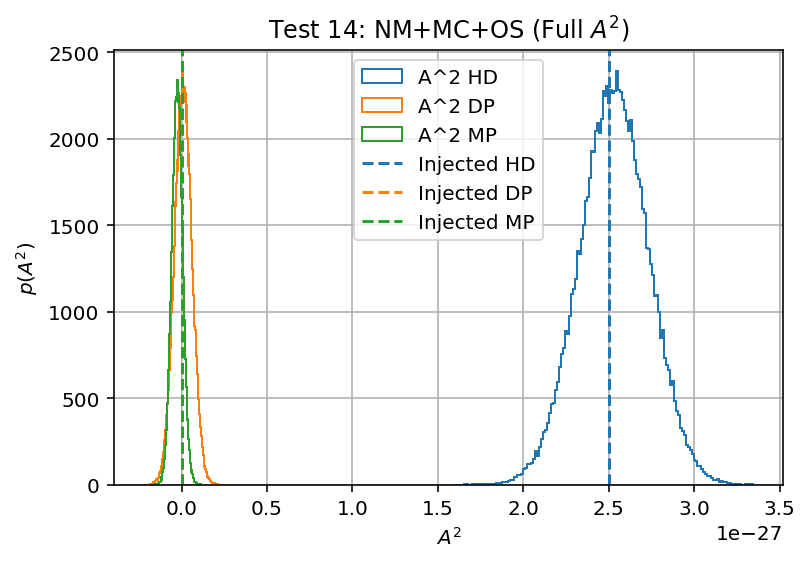

In [96]:
OS_obj.set_orf(['hd','dipole','monopole'])
A2,A2s,idx = OS_obj.compute_OS(N=1000, pair_covariance=False, return_pair_vals=False)

plt.title('Test 14: NM+MC+OS (Full $A^2$)')
full_A2 = utils.uncertainty_sample(A2,A2s,pfos=False,mcos=True)
plt.hist(full_A2[:,0],bins='auto',histtype='step',color='C0',label='A^2 HD')
plt.hist(full_A2[:,1],bins='auto',histtype='step',color='C1',label='A^2 DP')
plt.hist(full_A2[:,2],bins='auto',histtype='step',color='C2',label='A^2 MP')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='C0',label='Injected HD')
plt.axvline(0,linestyle='dashed',color='C1',label='Injected DP')
plt.axvline(0,linestyle='dashed',color='C2',label='Injected MP')

plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Test 15: PC+MC+OS <-Working Here

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params, N=1, pair_covariance=True, return_pair_vals=True)

plt.title('Test 15: PC+MC+OS (binned correlation)')
xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rho,C,bins=10,orf='hd')
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
plt.plot(xi_range,A2*hd_mod,'-r',label='Mean fit')
plt.fill_between(xi_range,(A2-A2s)*hd_mod,(A2+A2s)*hd_mod,color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()

# Test 16: PC+NM+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
A2,A2s,idx = OS_obj.compute_OS(N=100, pair_covariance=True, return_pair_vals=False)

plt.title('Test 16: PC+NM+MC+OS (Full $A^2$)')
full_A2 = utils.uncertainty_sample(A2,A2s)
plt.hist(full_A2,bins='auto',histtype='step',label='Full A^2 distribution')

plt.axvline(10**(2*inj_params['gw_log10_A']),linestyle='dashed',color='k',label='Injected')

plt.xlabel('$A^2$')
plt.ylabel('$p(A^2)$')
plt.grid()
plt.legend()
plt.show()

# Test 17: narrow PF+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=False, 
                                             return_pair_vals=True, narrowband=True)
fgw = OS_obj.freqs

plt.title('Test 17: narrow PF+MC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 5: narrow PF+MC+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10)
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 18: narrow PF+NM+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, pair_covariance=False, 
                                 return_pair_vals=False, narrowband=True)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 18: narrow PF+NM+MC+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 19: narrow PF+PC+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=True, 
                                             return_pair_vals=True, narrowband=True)
fgw = OS_obj.freqs

plt.title('Test 19: narrow PF+PC+MC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Narrowband PF+PC+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.loglog()
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 19: narrow PF+PC+MC+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],Ck[k],bins=10,orf='hd')
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 20: narrow PF+PC+NM+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=True)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 20: narrow PF+PC+NM+MC+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 21: PF+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=False, 
                                             return_pair_vals=True, narrowband=False)
fgw = OS_obj.freqs

plt.title('Test 21: PF+MC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 9: PF+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10)
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 22: PF+NM+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=1000, pair_covariance=False, 
                                 return_pair_vals=False, narrowband=False)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 22: PF+NM+MC+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()


# Test 23: PF+PC+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params, N=1, pair_covariance=True, 
                                             return_pair_vals=True, narrowband=False)
fgw = OS_obj.freqs

plt.title('Test 23: PF+PC+MC+OS spectrum')
plt.errorbar(fgw,Sk,Sks,fmt='.',capsize=3,label='Broadband PF+OS')
inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.loglog()
plt.plot(fgw,inj_pl,'--k',label='Injected')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()

for k in range(len(fgw)):
    plt.title(f'Test 23: PF+PC+MC+OS $f_{k+1}$ (binned correlation)')
    xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[k],sigk[k],bins=10,orf='hd')
    plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
    plt.plot(xi_range,Sk[k]*hd_mod,'-r',label='Mean fit')
    plt.fill_between(xi_range,(Sk[k]-Sks[k])*hd_mod,(Sk[k]+Sks[k])*hd_mod,color='r',alpha=0.1,label='1-sigma error')

    plt.plot(xi_range,inj_pl[k]*hd_mod,'--k',label='Injected')

    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated power')
    plt.grid()
    plt.legend()
    plt.show()

# Test 24: PF+PC+NM+MC+OS

In [ ]:
OS_obj.set_orf(['hd','dipole','monopole'])
Sk,Sks,idx = OS_obj.compute_PFOS(N=100, pair_covariance=True, 
                                 return_pair_vals=False, narrowband=False)
fgw = OS_obj.freqs

all_Sk = utils.uncertainty_sample(Sk,Sks)

plt.title('Test 24: PF+NM+MC+OS spectrum')
plt.violinplot(all_Sk.T,np.log10(fgw),widths=0.1,showmeans=True)

inj_pl = powerlaw(fgw,inj_params['gw_log10_A'],gamma=13./3.,components=1)
plt.plot(np.log10(fgw),inj_pl,'--k',label='Injected')

plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD($f_k$) [$s^2$]')
plt.legend()
plt.grid()
plt.show()
